In [1]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('https://www.dropbox.com/s/ia4tpu47h5f5ptd/train.csv?raw=1')
test = pd.read_csv('https://www.dropbox.com/s/7mjx3ulzrf2pde5/test.csv?raw=1')

# Data Processing

## Data Exploratory

**The distribution of genre in training set**

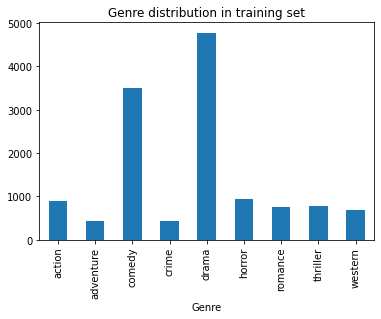

In [3]:
fig = plt.figure(figsize=(6,4))
train.groupby('Genre').Plot.count().plot.bar(ylim=0)
plt.title('Genre distribution in training set')
plt.show()

**The distribution of sentence lengths in training set and test set**

In [4]:
from pdtext.tf import word_count

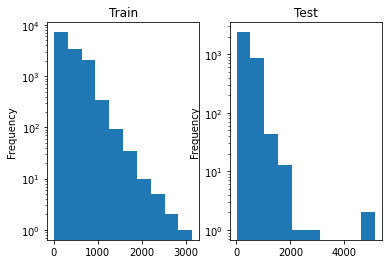

In [5]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
train['Plot'].apply(word_count).plot(kind='hist');
plt.yscale('log');
plt.title('Train');
plt.subplot(1, 2, 2)
test['Plot'].apply(word_count).plot(kind='hist');
plt.yscale('log');
plt.title('Test');

## Data Cleaning

In [6]:
def clean_plot(text):
    text = re.sub("\'", "", text) #Removing backslashes
    text = re.sub("[^a-zA-Z]"," ",text) #Keeping english alphabets only
    text = ' '.join(text.split()) #Striping extra white-spaces
    text = text.lower() #Normalizing text
    return text

In [7]:
train['plot_cleaned'] = train.Plot.apply(lambda x: clean_plot(x))
test['plot_cleaned'] = test.Plot.apply(lambda x: clean_plot(x))

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train['plot_cleaned'] = train['plot_cleaned'].apply(lambda x: remove_stopwords(x))
test['plot_cleaned'] = test['plot_cleaned'].apply(lambda x: remove_stopwords(x))

In [9]:
train.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,plot_cleaned
9659,1958,Return of the Fly,American,Edward Bernds,Vincent Price,horror,https://en.wikipedia.org/wiki/Return_of_the_Fly,"Now an adult, Phillipe Delambre (Brett Halsey)...",adult phillipe delambre brett halsey determine...
6604,2008,One Missed Call,American,Eric Valette,"Edward Burns, Shannyn Sossamon, Ana Claudia Ta...",horror,https://en.wikipedia.org/wiki/One_Missed_Call_...,The film begins with a young girl being rescue...,film begins young girl rescued burning hospita...
5085,1968,"Live a Little, Love a Little",American,Norman Taurog,"Elvis Presley, Michele Carey, Rudy Vallée",comedy,"https://en.wikipedia.org/wiki/Live_a_Little,_L...",Greg Nolan (Elvis) is a newspaper photographer...,greg nolan elvis newspaper photographer lives ...


In [10]:
test.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot,Id,plot_cleaned
42,1987,Summer School,American,Carl Reiner,"Mark Harmon, Kirstie Alley",https://en.wikipedia.org/wiki/Summer_School_(1...,On the last day of school before summer vacati...,42,last day school summer vacation physical educa...
166,2014,Android Cop,American,Mark Atkins,Michael Jai White\r\nKadeem Hardison\r\nRandy ...,https://en.wikipedia.org/wiki/Android_Cop,"In the year 2098, Los Angeles Police Departmen...",166,year los angeles police department detective h...
513,1981,Dead & Buried,American,Gary Sherman,"Melody Anderson, Jack Albertson",https://en.wikipedia.org/wiki/Dead_%26_Buried,"James Farentino stars as Dan Gillis, sheriff o...",513,james farentino stars dan gillis sheriff small...


In [11]:
from nltk.stem import *
def stem_corpus(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)
train['plot_cleaned'] = train['plot_cleaned'].apply(lambda x: stem_corpus(x))
test['plot_cleaned'] = test['plot_cleaned'].apply(lambda x: stem_corpus(x))

In [12]:
test.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot,Id,plot_cleaned
2508,2011,The Tunnel,Australian,Carlo Ledesma,NaN,https://en.wikipedia.org/wiki/The_Tunnel_(2011...,In the midst of the drought and water shortage...,2508,midst drought water shortages new south wales ...
1437,1976,Dixie Dynamite,American,Lee Frost,"Warren Oates, Christopher George",https://en.wikipedia.org/wiki/Dixie_Dynamite,A man who makes liquor illegally from a still ...,1437,man makes liquor illegally still cahoots sheri...
1116,1998,Zero Effect,American,Jake Kasdan,"Bill Pullman, Ryan O'Neal, Ben Stiller",https://en.wikipedia.org/wiki/Zero_Effect,"Daryl Zero is the world's greatest detective, ...",1116,daryl zero worlds greatest detective also soci...


In [13]:
train_data=train['plot_cleaned']
train_label=train['Genre']

In [14]:
test_data=test['plot_cleaned']
#test_label= pd.read_csv('sampleSubmission.csv')['Predicted']

## Tf-Idf Vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer = TfidfVectorizer(stop_words='english', 
                                   ngram_range=(1, 2), 
                                   lowercase=True, # default
                                   max_features=150000) 

In [16]:
X_train_text = text_transformer.fit_transform(train_data)
X_test_text = text_transformer.transform(test_data)

In [17]:
X_train_text.shape, X_test_text.shape

((13164, 150000), (3292, 150000))

# Model Buiding

## Logistic Regression

In [18]:
parameters = {'C' : [1,20,50],
              'solver' : ['liblinear', 'newton-cg'],
              'multi_class': ['multinomial','auto'],
              'penalty': ['l1','l2']
             }
grid = GridSearchCV(LogisticRegression(), 
                    parameters, 
                    cv = 5,
                    n_jobs = -1,
                    verbose = 10,
                    scoring='f1_micro'
                    )
grid.fit(X_train_text, train['Genre'])
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:  9.6min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.7min finished


0.6137952709184458
LogisticRegression(C=20, solver='liblinear')


In [19]:
test_preds = grid.predict(X_test_text)

In [20]:
pd.DataFrame(test_preds, columns=['Genre']).head()

,Genre
0,comedy
1,horror
2,drama
3,horror
4,romance


In [21]:
# test['Predicted'] = test_preds
# test[['Id','Predicted']].to_csv('Logistic.csv', index=False)

## SGDClassifier

In [22]:
# defining parameter range
parameters = {'alpha': [ 0.01, 0.001, 0.0001],
              'max_iter': [100,1000],
              'random_state': ['None',42],
              'early_stopping': [True,False]
             } 

grid = GridSearchCV(SGDClassifier(), 
                    parameters, 
                    cv = 5,
                    n_jobs = -1,
                    verbose = 3,
                    scoring='f1_micro')
# fitting the model for grid search
grid.fit(X_train_text, train['Genre'])
# grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   31.7s finished


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.001, 0.0001],
                         'early_stopping': [True, False],
                         'max_iter': [100, 1000],
                         'random_state': ['None', 42]},
             scoring='f1_micro', verbose=3)

In [23]:
print(grid.best_score_)
print(grid.best_estimator_)

0.6162263623843731
SGDClassifier(max_iter=100, random_state=42)


In [24]:
test_preds = grid.predict(X_test_text)

In [25]:
pd.DataFrame(test_preds, columns=['Genre']).head()

,Genre
0,comedy
1,horror
2,drama
3,horror
4,comedy


In [26]:
test['Predicted'] = test_preds
test[['Id','Predicted']].to_csv('SGDClassifier.csv', index=False)